<a href="https://colab.research.google.com/github/rorevillaca/GenISP/blob/main/Deep_Learning_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, utils

from torchsummary import summary
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

!pip install rawpy
import rawpy
import imageio
import cv2

import time
import os
import csv
import math
from google.colab.patches import cv2_imshow

from __future__ import print_function, division
import sys
import random
from torch.utils.data.sampler import Sampler
from pycocotools.coco import COCO

import skimage.io
import skimage.transform
import skimage.color
import skimage
from PIL import Image

import torch.utils.model_zoo as model_zoo
from torchvision.ops import nms
import collections

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x7ff83ed60310>
Traceback (most recent call last):
  File "/usr/lib/python3.9/_weakrefset.py", line 39, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt: 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.2 MB/s eta 0:00:00


In [ ]:
!gdown --id 1DpcTA3PM09x2ybqn_Zx_DxYdP3jCKBFg # RAW IMAGE
!gdown --id 170VFBDZ3vt-wvUECfHbxZLnNybpjfH6Z # .txt file w/ classes
!gdown --id 1qyYrciAJKyKbw762W1K3rT-GfsAkQYH4 # .cfg file w/ model
!gdown --id 1B0gLSyH5olYA7KEH_8fSAd8Pz-FCyly7 # model weights
!gdown --id 1clbdUESDxg-YZaW2qQgKp9xLelOAoyhw # zip with preprocessed images
!gdown --id 1yLmjq3JtXi841yXWBxst0coAgR26MNBS # state dict for Resnet 50

#raw_filename = '/content/DSC04386.ARW' 
raw_filename = '/content/DSC01401.ARW' 
yolov3_classes = '/content/yolov3_classes.txt'
yolov3_weights = '/content/yolov3-tiny.weights'
yolov3_cfg = '/content/yolov3-tiny.cfg'

resnet_state_dict = '/content/coco_resnet_50_map_0_335_state_dict.pt'


/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1DpcTA3PM09x2ybqn_Zx_DxYdP3jCKBFg
To: /content/DSC01401.ARW
100% 20.9M/20.9M [00:00<00:00, 59.8MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=170VFBDZ3vt-wvUECfHbxZLnNybpjfH6Z
To: /content/yolov3_classes.txt
100% 620/620 [00:00<00:00, 1.61MB/s]
/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/u

# **Preprocess Image**

-0.38182211683749845


torch.Size([1, 3, 256, 256])

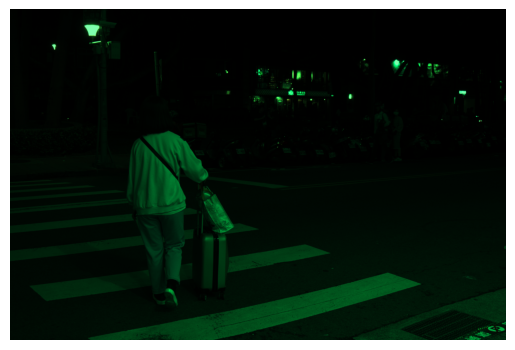

In [ ]:
def pack_avg_cst(raw_filename):
    with rawpy.imread(raw_filename) as raw:
        # Get raw image data
        image = np.array(raw.raw_image, dtype=np.double)
        
        # Substract black
        black = np.reshape(np.array(raw.black_level_per_channel, dtype=np.double), (2, 2))
        black = np.tile(black, (image.shape[0]//2, image.shape[1]//2))
        image = (image - black) / (raw.white_level - black)

        # Get the raw pattern of the photo
        n_colors = raw.num_colors
        colors = np.frombuffer(raw.color_desc, dtype=np.byte)
        pattern = np.array(raw.raw_pattern)
        i_0 = np.where(colors[pattern] == colors[0])
        i_1 = np.where(colors[pattern] == colors[1])
        i_2 = np.where(colors[pattern] == colors[2])

        # Pack image and average the green channels
        image_packed = np.empty((image.shape[0]//2, image.shape[1]//2, n_colors))
        
        image_packed[:, :, 0] = image[i_0[0][0]::2, i_0[1][0]::2]
        image_packed[:, :, 1]  = (image[i_1[0][0]::2, i_1[1][0]::2] + image[i_1[0][1]::2, i_1[1][1]::2]) / 2
        image_packed[:, :, 2]  = image[i_2[0][0]::2, i_2[1][0]::2]

        # CST Conversion
        cst = raw.rgb_xyz_matrix[0:3, :]
        image_XYZ = np.einsum('ij,...j', cst, image_packed)
        #image_XYZ = np.clip(image_XYZ, 0, 1)
        print(np.min(image_XYZ))
        plt.axis('off')
        plt.imshow(image_XYZ)

        image_XYZ = torch.from_numpy(image_XYZ).unsqueeze(0)


        return image_XYZ #Returns Tensor with size [1,H,W,C]

def resize_256(image):
    resized_256 = image.permute(0, 3, 1, 2) 
    resized_256 = F.interpolate(resized_256, size=(256, 256), mode='bilinear')
    return resized_256

prep_image = pack_avg_cst(raw_filename)
resized_image = resize_256(prep_image)
resized_image.shape

# **Load Preprocessed Images**

In [ ]:
!unzip '/content/preprocessed_pngs_small.zip' -d '/content/'

Archive:  /content/preprocessed_pngs_small.zip
  inflating: /content/preprocessed_pngs/DSC01093.png  
  inflating: /content/preprocessed_pngs/DSC01103.png  
  inflating: /content/preprocessed_pngs/DSC01157.png  
  inflating: /content/preprocessed_pngs/DSC01164.png  
  inflating: /content/preprocessed_pngs/DSC01248.png  
  inflating: /content/preprocessed_pngs/DSC01300.png  
  inflating: /content/preprocessed_pngs/DSC01312.png  
  inflating: /content/preprocessed_pngs/DSC01327.png  
  inflating: /content/preprocessed_pngs/DSC01332.png  
  inflating: /content/preprocessed_pngs/DSC01333.png  
  inflating: /content/preprocessed_pngs/DSC01378.png  
  inflating: /content/preprocessed_pngs/DSC01402.png  
  inflating: /content/preprocessed_pngs/DSC01453.png  
  inflating: /content/preprocessed_pngs/DSC01618.png  
  inflating: /content/preprocessed_pngs/DSC01796.png  
  inflating: /content/preprocessed_pngs/DSC01882.png  
  inflating: /content/preprocessed_pngs/DSC01910.png  
  inflating: /cont

In [ ]:
from PIL import Image
import numpy as np
import os

dir_path = '/content/preprocessed_pngs/'
file_list = os.listdir(dir_path)
# print(len(file_list))
im_frame = []
for i in range(1, int(len(file_list)/6)):
  image = Image.open(dir_path + file_list[i])
  print(dir_path + file_list[i])
  image = np.array(image)
  im_frame.append(image)
# im_frame.append(Image.open(dir_path + file_list[50]))
# im_frame = Image.open(dir_path + file_list[63])
np_frame = np.array(im_frame)
# im_frame.shape
# np_frame = np.array(im_frame, dtype = np.double)
# np_frame = np_frame[:,:,:3]
np_frame.shape

/content/preprocessed_pngs/DSC01333.png
/content/preprocessed_pngs/DSC01995.png
/content/preprocessed_pngs/DSC02594.png
/content/preprocessed_pngs/DSC02759.png
/content/preprocessed_pngs/DSC02850.png
/content/preprocessed_pngs/DSC01164.png
/content/preprocessed_pngs/DSC04411.png
/content/preprocessed_pngs/DSC01378.png
/content/preprocessed_pngs/DSC01157.png
/content/preprocessed_pngs/DSC03611.png
/content/preprocessed_pngs/DSC03815.png
/content/preprocessed_pngs/DSC01979.png


(12, 1836, 2752, 3)

In [ ]:
def resize_256(image):
    print(image.shape)
    resized_256 = image.permute(0, 3, 1, 2)
    # print(resized_256.shape)
    resized_256 = F.interpolate(resized_256, size=(256, 256))
    return resized_256

prep_image = torch.from_numpy(np_frame)
resized_image = resize_256(prep_image)
resized_image = resized_image.to(torch.double)
resized_image.dtype

torch.Size([12, 1836, 2752, 3])


torch.float64

# **Image to Parameters**

### WB

In [ ]:
from torchvision.ops import MLP
class WBNet(nn.Module):
    def __init__(self):
        super(WBNet, self).__init__()
        self.cnn1 = nn.Conv2d(3, 16, (7, 7))
        self.max1 = nn.MaxPool2d((4, 4))
        self.cnn2 = nn.Conv2d(16, 32, (5, 5))
        self.max2 = nn.MaxPool2d((3, 3))
        self.cnn3 = nn.Conv2d(32, 64, (3,3))
        self.max3 = nn.MaxPool2d((2, 2))
        self.aap1 = nn.AdaptiveAvgPool2d(1)
        self.mlp = MLP(in_channels = 64, hidden_channels = [3])
        
    def forward(self, x):
        h = nn.functional.leaky_relu(self.cnn1(x))
        h = self.max1(h)
        h = nn.functional.leaky_relu(self.cnn2(h))
        h = self.max2(h)
        h = nn.functional.leaky_relu(self.cnn3(h))
        h = self.max3(h)
        h = self.aap1(h)
        h = h.reshape(h.size(0), -1)
        h = self.mlp(h)
        return h
summary(WBNet(), (3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 250, 250]           2,368
         MaxPool2d-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 58, 58]          12,832
         MaxPool2d-4           [-1, 32, 19, 19]               0
            Conv2d-5           [-1, 64, 17, 17]          18,496
         MaxPool2d-6             [-1, 64, 8, 8]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Linear-8                    [-1, 3]             195
           Dropout-9                    [-1, 3]               0
Total params: 33,891
Trainable params: 33,891
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 9.18
Params size (MB): 0.13
Estimated Total Size (MB): 10.06
--------------------------------------------

In [ ]:
class CCNet(nn.Module):
    """
    Simple fully connected neural network with residual connections in PyTorch.
    Layers are defined in __init__ and forward pass implemented in forward.
    """
    
    def __init__(self):
        super(CCNet, self).__init__()

        self.cnn1 = nn.Conv2d(3, 16, (7, 7))
        self.max1 = nn.MaxPool2d((4, 4))
        self.cnn2 = nn.Conv2d(16, 32, (5, 5))
        self.max2 = nn.MaxPool2d((3, 3))
        self.cnn3 = nn.Conv2d(32, 64, (3,3))
        self.max3 = nn.MaxPool2d((2, 2))
        self.aap1 = nn.AdaptiveAvgPool2d(3)

        self.fc1 = nn.Linear(576, 15)
        self.fc2 = nn.Linear(15, 9)
        
    def forward(self, x):
        h = nn.functional.leaky_relu(self.cnn1(x))
        h = self.max1(h)
        h = nn.functional.leaky_relu(self.cnn2(h))
        h = self.max2(h)
        h = nn.functional.leaky_relu(self.cnn3(h))
        h = self.max3(h)
        h = self.aap1(h)
        h = h.reshape(h.size(0), -1)
        # print(h.shape)
        h = self.fc1(h)
        # h = nn.functional.leaky_relu(h)
        h = self.fc2(h)
        return h

# Print network architecture using torchsummary
summary(CCNet(), (3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 250, 250]           2,368
         MaxPool2d-2           [-1, 16, 62, 62]               0
            Conv2d-3           [-1, 32, 58, 58]          12,832
         MaxPool2d-4           [-1, 32, 19, 19]               0
            Conv2d-5           [-1, 64, 17, 17]          18,496
         MaxPool2d-6             [-1, 64, 8, 8]               0
 AdaptiveAvgPool2d-7             [-1, 64, 3, 3]               0
            Linear-8                   [-1, 15]           8,655
            Linear-9                    [-1, 9]             144
Total params: 42,495
Trainable params: 42,495
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 9.18
Params size (MB): 0.16
Estimated Total Size (MB): 10.10
--------------------------------------------

In [ ]:
# Move inside train.py
wb = WBNet()
wb.to(torch.double)
output = wb(resized_image)

output = torch.mean(output, 0)
output = torch.diag(output)

In [ ]:
# Move inside train.py
img = prep_image
img = img.to(torch.double)
new_image_wb = torch.matmul(img, output)
new_image_wb.shape

torch.Size([12, 1836, 2752, 3])

In [ ]:
# Move inside train.py
resized_image = resize_256(new_image_wb)
resized_image = resized_image.to(torch.double)
resized_image.shape

torch.Size([12, 1836, 2752, 3])


torch.Size([12, 3, 256, 256])

### WC

In [ ]:
# Move inside train.py
cc = CCNet()
cc.to(torch.double)
output = cc(resized_image)
output = torch.mean(output, 0)
output = output.reshape(3,3)

In [ ]:
# Move inside train.py
img = new_image_wb

In [ ]:
# Move inside train.py
new_image_cc = torch.matmul(img, output)
# new_image_cc.shape
new_image_cc = new_image_cc.permute(0, 3, 1, 2)
new_image_cc.dtype

torch.float64


## Shallow ConvNet

In [ ]:
#final_images = ConvNet()
#final_images.to(torch.double)
#trained_image = final_images(new_image_cc)
#trained_image

# x = final_images.deepcopy()

In [ ]:
trained_image = new_image_cc

class ConvNet(nn.Module):
    """
    Simple fully connected neural network with residual connections in PyTorch.
    Layers are defined in __init__ and forward pass implemented in forward.
    """
    
    def __init__(self):
        super(ConvNet, self).__init__()

        self.cnn1 = nn.Conv2d(3, 16, (3, 3))
        self.in01 = nn.InstanceNorm2d(16)
        self.cnn2 = nn.Conv2d(16, 64, (3, 3))
        self.in02 = nn.InstanceNorm2d(64)
        self.cnn3 = nn.Conv2d(64, 3, (1, 1))

    def forward(self, x):
        # h = nn.LeakyReLU(self.cnn1(x))
        h = nn.functional.leaky_relu(self.in01(self.cnn1(x)))
        h = nn.functional.leaky_relu(self.in02(self.cnn2(h)))
        return self.cnn3(h)

# Print network architecture using torchsummary
summary(ConvNet(), (3, 1836, 2752), device='cpu')

# RetinaNet

In [ ]:
## RetinaNet Utils

import torch
import torch.nn as nn


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class BBoxTransform(nn.Module):

    def __init__(self, mean=None, std=None):
        super(BBoxTransform, self).__init__()
        if mean is None:
            if torch.cuda.is_available():
                self.mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32)).cuda()
            else:
                self.mean = torch.from_numpy(np.array([0, 0, 0, 0]).astype(np.float32))

        else:
            self.mean = mean
        if std is None:
            if torch.cuda.is_available():
                self.std = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32)).cuda()
            else:
                self.std = torch.from_numpy(np.array([0.1, 0.1, 0.2, 0.2]).astype(np.float32))
        else:
            self.std = std

    def forward(self, boxes, deltas):

        widths  = boxes[:, :, 2] - boxes[:, :, 0]
        heights = boxes[:, :, 3] - boxes[:, :, 1]
        ctr_x   = boxes[:, :, 0] + 0.5 * widths
        ctr_y   = boxes[:, :, 1] + 0.5 * heights

        dx = deltas[:, :, 0] * self.std[0] + self.mean[0]
        dy = deltas[:, :, 1] * self.std[1] + self.mean[1]
        dw = deltas[:, :, 2] * self.std[2] + self.mean[2]
        dh = deltas[:, :, 3] * self.std[3] + self.mean[3]

        pred_ctr_x = ctr_x + dx * widths
        pred_ctr_y = ctr_y + dy * heights
        pred_w     = torch.exp(dw) * widths
        pred_h     = torch.exp(dh) * heights

        pred_boxes_x1 = pred_ctr_x - 0.5 * pred_w
        pred_boxes_y1 = pred_ctr_y - 0.5 * pred_h
        pred_boxes_x2 = pred_ctr_x + 0.5 * pred_w
        pred_boxes_y2 = pred_ctr_y + 0.5 * pred_h

        pred_boxes = torch.stack([pred_boxes_x1, pred_boxes_y1, pred_boxes_x2, pred_boxes_y2], dim=2)

        return pred_boxes


class ClipBoxes(nn.Module):

    def __init__(self, width=None, height=None):
        super(ClipBoxes, self).__init__()

    def forward(self, boxes, img):

        batch_size, num_channels, height, width = img.shape

        boxes[:, :, 0] = torch.clamp(boxes[:, :, 0], min=0)
        boxes[:, :, 1] = torch.clamp(boxes[:, :, 1], min=0)

        boxes[:, :, 2] = torch.clamp(boxes[:, :, 2], max=width)
        boxes[:, :, 3] = torch.clamp(boxes[:, :, 3], max=height)
      
        return boxes


In [ ]:
## Anchors

class Anchors(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, sizes=None, ratios=None, scales=None):
        super(Anchors, self).__init__()

        if pyramid_levels is None:
            self.pyramid_levels = [3, 4, 5, 6, 7]
        if strides is None:
            self.strides = [2 ** x for x in self.pyramid_levels]
        if sizes is None:
            self.sizes = [2 ** (x + 2) for x in self.pyramid_levels]
        if ratios is None:
            self.ratios = np.array([0.5, 1, 2])
        if scales is None:
            self.scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    def forward(self, image):
        
        image_shape = image.shape[2:]
        image_shape = np.array(image_shape)
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]

        # compute anchors over all pyramid levels
        all_anchors = np.zeros((0, 4)).astype(np.float32)

        for idx, p in enumerate(self.pyramid_levels):
            anchors         = generate_anchors(base_size=self.sizes[idx], ratios=self.ratios, scales=self.scales)
            shifted_anchors = shift(image_shapes[idx], self.strides[idx], anchors)
            all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)

        all_anchors = np.expand_dims(all_anchors, axis=0)

        if torch.cuda.is_available():
            return torch.from_numpy(all_anchors.astype(np.float32)).cuda()
        else:
            return torch.from_numpy(all_anchors.astype(np.float32))

def generate_anchors(base_size=16, ratios=None, scales=None):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales w.r.t. a reference window.
    """

    if ratios is None:
        ratios = np.array([0.5, 1, 2])

    if scales is None:
        scales = np.array([2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

    num_anchors = len(ratios) * len(scales)

    # initialize output anchors
    anchors = np.zeros((num_anchors, 4))

    # scale base_size
    anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T

    # compute areas of anchors
    areas = anchors[:, 2] * anchors[:, 3]

    # correct for ratios
    anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
    anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))

    # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
    anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
    anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

    return anchors

def compute_shape(image_shape, pyramid_levels):
    """Compute shapes based on pyramid levels.

    :param image_shape:
    :param pyramid_levels:
    :return:
    """
    image_shape = np.array(image_shape[:2])
    image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in pyramid_levels]
    return image_shapes


def anchors_for_shape(
    image_shape,
    pyramid_levels=None,
    ratios=None,
    scales=None,
    strides=None,
    sizes=None,
    shapes_callback=None,
):

    image_shapes = compute_shape(image_shape, pyramid_levels)

    # compute anchors over all pyramid levels
    all_anchors = np.zeros((0, 4))
    for idx, p in enumerate(pyramid_levels):
        anchors         = generate_anchors(base_size=sizes[idx], ratios=ratios, scales=scales)
        shifted_anchors = shift(image_shapes[idx], strides[idx], anchors)
        all_anchors     = np.append(all_anchors, shifted_anchors, axis=0)

    return all_anchors


def shift(shape, stride, anchors):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride

    shift_x, shift_y = np.meshgrid(shift_x, shift_y)

    shifts = np.vstack((
        shift_x.ravel(), shift_y.ravel(),
        shift_x.ravel(), shift_y.ravel()
    )).transpose()

    # add A anchors (1, A, 4) to
    # cell K shifts (K, 1, 4) to get
    # shift anchors (K, A, 4)
    # reshape to (K*A, 4) shifted anchors
    A = anchors.shape[0]
    K = shifts.shape[0]
    all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    all_anchors = all_anchors.reshape((K * A, 4))

    return all_anchors

In [ ]:
## Losses

def calc_iou(a, b):
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = torch.min(torch.unsqueeze(a[:, 2], dim=1), b[:, 2]) - torch.max(torch.unsqueeze(a[:, 0], 1), b[:, 0])
    ih = torch.min(torch.unsqueeze(a[:, 3], dim=1), b[:, 3]) - torch.max(torch.unsqueeze(a[:, 1], 1), b[:, 1])

    iw = torch.clamp(iw, min=0)
    ih = torch.clamp(ih, min=0)

    ua = torch.unsqueeze((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), dim=1) + area - iw * ih

    ua = torch.clamp(ua, min=1e-8)

    intersection = iw * ih

    IoU = intersection / ua

    return IoU

class FocalLoss(nn.Module):
    #def __init__(self):

    def forward(self, classifications, regressions, anchors, annotations):
        alpha = 0.25
        gamma = 2.0
        batch_size = classifications.shape[0]
        classification_losses = []
        regression_losses = []

        anchor = anchors[0, :, :]

        anchor_widths  = anchor[:, 2] - anchor[:, 0]
        anchor_heights = anchor[:, 3] - anchor[:, 1]
        anchor_ctr_x   = anchor[:, 0] + 0.5 * anchor_widths
        anchor_ctr_y   = anchor[:, 1] + 0.5 * anchor_heights

        for j in range(batch_size):

            classification = classifications[j, :, :]
            regression = regressions[j, :, :]

            bbox_annotation = annotations[j, :, :]
            bbox_annotation = bbox_annotation[bbox_annotation[:, 4] != -1]

            classification = torch.clamp(classification, 1e-4, 1.0 - 1e-4)

            if bbox_annotation.shape[0] == 0:
                if torch.cuda.is_available():
                    alpha_factor = torch.ones(classification.shape).cuda() * alpha

                    alpha_factor = 1. - alpha_factor
                    focal_weight = classification
                    focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

                    bce = -(torch.log(1.0 - classification))

                    # cls_loss = focal_weight * torch.pow(bce, gamma)
                    cls_loss = focal_weight * bce
                    classification_losses.append(cls_loss.sum())
                    regression_losses.append(torch.tensor(0).float().cuda())

                else:
                    alpha_factor = torch.ones(classification.shape) * alpha

                    alpha_factor = 1. - alpha_factor
                    focal_weight = classification
                    focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

                    bce = -(torch.log(1.0 - classification))

                    # cls_loss = focal_weight * torch.pow(bce, gamma)
                    cls_loss = focal_weight * bce
                    classification_losses.append(cls_loss.sum())
                    regression_losses.append(torch.tensor(0).float())

                continue

            IoU = calc_iou(anchors[0, :, :], bbox_annotation[:, :4]) # num_anchors x num_annotations

            IoU_max, IoU_argmax = torch.max(IoU, dim=1) # num_anchors x 1

            #import pdb
            #pdb.set_trace()

            # compute the loss for classification
            targets = torch.ones(classification.shape) * -1

            if torch.cuda.is_available():
                targets = targets.cuda()

            targets[torch.lt(IoU_max, 0.4), :] = 0

            positive_indices = torch.ge(IoU_max, 0.5)

            num_positive_anchors = positive_indices.sum()

            assigned_annotations = bbox_annotation[IoU_argmax, :]

            targets[positive_indices, :] = 0
            targets[positive_indices, assigned_annotations[positive_indices, 4].long()] = 1

            if torch.cuda.is_available():
                alpha_factor = torch.ones(targets.shape).cuda() * alpha
            else:
                alpha_factor = torch.ones(targets.shape) * alpha

            alpha_factor = torch.where(torch.eq(targets, 1.), alpha_factor, 1. - alpha_factor)
            focal_weight = torch.where(torch.eq(targets, 1.), 1. - classification, classification)
            focal_weight = alpha_factor * torch.pow(focal_weight, gamma)

            bce = -(targets * torch.log(classification) + (1.0 - targets) * torch.log(1.0 - classification))

            # cls_loss = focal_weight * torch.pow(bce, gamma)
            cls_loss = focal_weight * bce

            if torch.cuda.is_available():
                cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape).cuda())
            else:
                cls_loss = torch.where(torch.ne(targets, -1.0), cls_loss, torch.zeros(cls_loss.shape))

            classification_losses.append(cls_loss.sum()/torch.clamp(num_positive_anchors.float(), min=1.0))

            # compute the loss for regression

            if positive_indices.sum() > 0:
                assigned_annotations = assigned_annotations[positive_indices, :]

                anchor_widths_pi = anchor_widths[positive_indices]
                anchor_heights_pi = anchor_heights[positive_indices]
                anchor_ctr_x_pi = anchor_ctr_x[positive_indices]
                anchor_ctr_y_pi = anchor_ctr_y[positive_indices]

                gt_widths  = assigned_annotations[:, 2] - assigned_annotations[:, 0]
                gt_heights = assigned_annotations[:, 3] - assigned_annotations[:, 1]
                gt_ctr_x   = assigned_annotations[:, 0] + 0.5 * gt_widths
                gt_ctr_y   = assigned_annotations[:, 1] + 0.5 * gt_heights

                # clip widths to 1
                gt_widths  = torch.clamp(gt_widths, min=1)
                gt_heights = torch.clamp(gt_heights, min=1)

                targets_dx = (gt_ctr_x - anchor_ctr_x_pi) / anchor_widths_pi
                targets_dy = (gt_ctr_y - anchor_ctr_y_pi) / anchor_heights_pi
                targets_dw = torch.log(gt_widths / anchor_widths_pi)
                targets_dh = torch.log(gt_heights / anchor_heights_pi)

                targets = torch.stack((targets_dx, targets_dy, targets_dw, targets_dh))
                targets = targets.t()

                if torch.cuda.is_available():
                    targets = targets/torch.Tensor([[0.1, 0.1, 0.2, 0.2]]).cuda()
                else:
                    targets = targets/torch.Tensor([[0.1, 0.1, 0.2, 0.2]])

                negative_indices = 1 + (~positive_indices)

                regression_diff = torch.abs(targets - regression[positive_indices, :])

                regression_loss = torch.where(
                    torch.le(regression_diff, 1.0 / 9.0),
                    0.5 * 9.0 * torch.pow(regression_diff, 2),
                    regression_diff - 0.5 / 9.0
                )
                regression_losses.append(regression_loss.mean())
            else:
                if torch.cuda.is_available():
                    regression_losses.append(torch.tensor(0).float().cuda())
                else:
                    regression_losses.append(torch.tensor(0).float())

        return torch.stack(classification_losses).mean(dim=0, keepdim=True), torch.stack(regression_losses).mean(dim=0, keepdim=True)

In [ ]:
## Model

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


class PyramidFeatures(nn.Module):
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        super(PyramidFeatures, self).__init__()

        # upsample C5 to get P5 from the FPN paper
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P5 elementwise to C4
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # add P4 elementwise to C3
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1, stride=1, padding=0)
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=1, padding=1)

        # "P6 is obtained via a 3x3 stride-2 conv on C5"
        self.P6 = nn.Conv2d(C5_size, feature_size, kernel_size=3, stride=2, padding=1)

        # "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
        self.P7_1 = nn.ReLU()
        self.P7_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, stride=2, padding=1)

    def forward(self, inputs):
        C3, C4, C5 = inputs

        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)

        P4_x = self.P4_1(C4)
        P4_x = P5_upsampled_x + P4_x
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P4_x = self.P4_2(P4_x)

        P3_x = self.P3_1(C3)
        P3_x = P3_x + P4_upsampled_x
        P3_x = self.P3_2(P3_x)

        P6_x = self.P6(C5)

        P7_x = self.P7_1(P6_x)
        P7_x = self.P7_2(P7_x)

        return [P3_x, P4_x, P5_x, P6_x, P7_x]


class RegressionModel(nn.Module):
    def __init__(self, num_features_in, num_anchors=9, feature_size=256):
        super(RegressionModel, self).__init__()

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * 4, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)

        # out is B x C x W x H, with C = 4*num_anchors
        out = out.permute(0, 2, 3, 1)

        return out.contiguous().view(out.shape[0], -1, 4)


class ClassificationModel(nn.Module):
    def __init__(self, num_features_in, num_anchors=9, num_classes=80, prior=0.01, feature_size=256):
        super(ClassificationModel, self).__init__()

        self.num_classes = num_classes
        self.num_anchors = num_anchors

        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()

        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()

        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()

        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()

        self.output = nn.Conv2d(feature_size, num_anchors * num_classes, kernel_size=3, padding=1)
        self.output_act = nn.Sigmoid()

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)

        out = self.conv2(out)
        out = self.act2(out)

        out = self.conv3(out)
        out = self.act3(out)

        out = self.conv4(out)
        out = self.act4(out)

        out = self.output(out)
        out = self.output_act(out)

        # out is B x C x W x H, with C = n_classes + n_anchors
        out1 = out.permute(0, 2, 3, 1)

        batch_size, width, height, channels = out1.shape

        out2 = out1.view(batch_size, width, height, self.num_anchors, self.num_classes)

        return out2.contiguous().view(x.shape[0], -1, self.num_classes)


class ResNet(nn.Module):

    def __init__(self, num_classes, block, layers):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        if block == BasicBlock:
            fpn_sizes = [self.layer2[layers[1] - 1].conv2.out_channels, self.layer3[layers[2] - 1].conv2.out_channels,
                         self.layer4[layers[3] - 1].conv2.out_channels]
        elif block == Bottleneck:
            fpn_sizes = [self.layer2[layers[1] - 1].conv3.out_channels, self.layer3[layers[2] - 1].conv3.out_channels,
                         self.layer4[layers[3] - 1].conv3.out_channels]
        else:
            raise ValueError(f"Block type {block} not understood")

        self.fpn = PyramidFeatures(fpn_sizes[0], fpn_sizes[1], fpn_sizes[2])

        self.regressionModel = RegressionModel(256)
        self.classificationModel = ClassificationModel(256, num_classes=num_classes)

        self.anchors = Anchors()

        self.regressBoxes = BBoxTransform()

        self.clipBoxes = ClipBoxes()

        self.focalLoss = FocalLoss()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        prior = 0.01

        self.classificationModel.output.weight.data.fill_(0)
        self.classificationModel.output.bias.data.fill_(-math.log((1.0 - prior) / prior))

        self.regressionModel.output.weight.data.fill_(0)
        self.regressionModel.output.bias.data.fill_(0)

        self.freeze_bn()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def freeze_bn(self):
        '''Freeze BatchNorm layers.'''
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    def print_layers(self):
        for layer in self.modules():
            print(layer)

    def forward(self, inputs):

        if self.training:
            img_batch, annotations = inputs
        else:
            img_batch = inputs

        x = self.conv1(img_batch)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        features = self.fpn([x2, x3, x4])

        regression = torch.cat([self.regressionModel(feature) for feature in features], dim=1)

        classification = torch.cat([self.classificationModel(feature) for feature in features], dim=1)

        anchors = self.anchors(img_batch)

        if self.training:
            return self.focalLoss(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, img_batch)

            finalResult = [[], [], []]

            finalScores = torch.Tensor([])
            finalAnchorBoxesIndexes = torch.Tensor([]).long()
            finalAnchorBoxesCoordinates = torch.Tensor([])

            if torch.cuda.is_available():
                finalScores = finalScores.cuda()
                finalAnchorBoxesIndexes = finalAnchorBoxesIndexes.cuda()
                finalAnchorBoxesCoordinates = finalAnchorBoxesCoordinates.cuda()

            for i in range(classification.shape[2]):
                scores = torch.squeeze(classification[:, :, i])
                scores_over_thresh = (scores > 0.05)
                if scores_over_thresh.sum() == 0:
                    # no boxes to NMS, just continue
                    continue

                scores = scores[scores_over_thresh]
                anchorBoxes = torch.squeeze(transformed_anchors)
                anchorBoxes = anchorBoxes[scores_over_thresh]
                anchors_nms_idx = nms(anchorBoxes, scores, 0.5)

                finalResult[0].extend(scores[anchors_nms_idx])
                finalResult[1].extend(torch.tensor([i] * anchors_nms_idx.shape[0]))
                finalResult[2].extend(anchorBoxes[anchors_nms_idx])

                finalScores = torch.cat((finalScores, scores[anchors_nms_idx]))
                finalAnchorBoxesIndexesValue = torch.tensor([i] * anchors_nms_idx.shape[0])
                if torch.cuda.is_available():
                    finalAnchorBoxesIndexesValue = finalAnchorBoxesIndexesValue.cuda()

                finalAnchorBoxesIndexes = torch.cat((finalAnchorBoxesIndexes, finalAnchorBoxesIndexesValue))
                finalAnchorBoxesCoordinates = torch.cat((finalAnchorBoxesCoordinates, anchorBoxes[anchors_nms_idx]))

            return [finalScores, finalAnchorBoxesIndexes, finalAnchorBoxesCoordinates]



def resnet18(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18'], model_dir='.'), strict=False)
    return model


def resnet34(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34'], model_dir='.'), strict=False)
    return model


def resnet50(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(torch.load('coco_resnet_50_map_0_335_state_dict.pt', map_location=torch.device('cpu')), strict=False)
    return model


def resnet101(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101'], model_dir='.'), strict=False)
    return model


def resnet152(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152'], model_dir='.'), strict=False)
    return model

In [ ]:
## Dataloader

class CSVDataset(Dataset):
    """CSV dataset."""

    def __init__(self, train_file, class_list, transform=None):
        """
        Args:
            train_file (string): CSV file with training annotations
            annotations (string): CSV file with class list
            test_file (string, optional): CSV file with testing annotations
        """
        self.train_file = train_file
        self.class_list = class_list
        self.transform = transform

        # parse the provided class file
        try:
            with self._open_for_csv(self.class_list) as file:
                self.classes = self.load_classes(csv.reader(file, delimiter=','))
        except ValueError as e:
            raise(ValueError('invalid CSV class file: {}: {}'.format(self.class_list, e)))

        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key

        # csv with img_path, x1, y1, x2, y2, class_name
        try:
            with self._open_for_csv(self.train_file) as file:
                self.image_data = self._read_annotations(csv.reader(file, delimiter=','), self.classes)
        except ValueError as e:
            raise(ValueError('invalid CSV annotations file: {}: {}'.format(self.train_file, e)))
        self.image_names = list(self.image_data.keys())

    def _parse(self, value, function, fmt):
        """
        Parse a string into a value, and format a nice ValueError if it fails.
        Returns `function(value)`.
        Any `ValueError` raised is catched and a new `ValueError` is raised
        with message `fmt.format(e)`, where `e` is the caught `ValueError`.
        """
        try:
            return function(value)
        except ValueError as e:
            raise_from(ValueError(fmt.format(e)), None)

    def _open_for_csv(self, path):
        """
        Open a file with flags suitable for csv.reader.
        This is different for python2 it means with mode 'rb',
        for python3 this means 'r' with "universal newlines".
        """
        if sys.version_info[0] < 3:
            return open(path, 'rb')
        else:
            return open(path, 'r', newline='')

    def load_classes(self, csv_reader):
        result = {}

        for line, row in enumerate(csv_reader):
            line += 1

            try:
                class_name, class_id = row
            except ValueError:
                raise(ValueError('line {}: format should be \'class_name,class_id\''.format(line)))
            class_id = self._parse(class_id, int, 'line {}: malformed class ID: {{}}'.format(line))

            if class_name in result:
                raise ValueError('line {}: duplicate class name: \'{}\''.format(line, class_name))
            result[class_name] = class_id
        return result

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        img = self.load_image(idx)
        annot = self.load_annotations(idx)
        sample = {'img': img, 'annot': annot}
        if self.transform:
            sample = self.transform(sample)

        return sample

    def load_image(self, image_index):
        img = skimage.io.imread(self.image_names[image_index])

        if len(img.shape) == 2:
            img = skimage.color.gray2rgb(img)

        return img.astype(np.float32)/255.0

    def load_annotations(self, image_index):
        # get ground truth annotations
        annotation_list = self.image_data[self.image_names[image_index]]
        annotations     = np.zeros((0, 5))

        # some images appear to miss annotations (like image with id 257034)
        if len(annotation_list) == 0:
            return annotations

        # parse annotations
        for idx, a in enumerate(annotation_list):
            # some annotations have basically no width / height, skip them
            x1 = a['x1']
            x2 = a['x2']
            y1 = a['y1']
            y2 = a['y2']

            if (x2-x1) < 1 or (y2-y1) < 1:
                continue

            annotation        = np.zeros((1, 5))
            
            annotation[0, 0] = x1
            annotation[0, 1] = y1
            annotation[0, 2] = x2
            annotation[0, 3] = y2

            annotation[0, 4]  = self.name_to_label(a['class'])
            annotations       = np.append(annotations, annotation, axis=0)

        return annotations

    def _read_annotations(self, csv_reader, classes):
        result = {}
        for line, row in enumerate(csv_reader):
            line += 1

            try:
                img_file, x1, y1, x2, y2, class_name = row[:6]
            except ValueError:
                raise_from(ValueError('line {}: format should be \'img_file,x1,y1,x2,y2,class_name\' or \'img_file,,,,,\''.format(line)), None)

            if img_file not in result:
                result[img_file] = []

            # If a row contains only an image path, it's an image without annotations.
            if (x1, y1, x2, y2, class_name) == ('', '', '', '', ''):
                continue

            x1 = self._parse(x1, int, 'line {}: malformed x1: {{}}'.format(line))
            y1 = self._parse(y1, int, 'line {}: malformed y1: {{}}'.format(line))
            x2 = self._parse(x2, int, 'line {}: malformed x2: {{}}'.format(line))
            y2 = self._parse(y2, int, 'line {}: malformed y2: {{}}'.format(line))

            # Check that the bounding box is valid.
            if x2 <= x1:
                raise ValueError('line {}: x2 ({}) must be higher than x1 ({})'.format(line, x2, x1))
            if y2 <= y1:
                raise ValueError('line {}: y2 ({}) must be higher than y1 ({})'.format(line, y2, y1))

            # check if the current class name is correctly present
            if class_name not in classes:
                raise ValueError('line {}: unknown class name: \'{}\' (classes: {})'.format(line, class_name, classes))

            result[img_file].append({'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': class_name})
        return result

    def name_to_label(self, name):
        return self.classes[name]

    def label_to_name(self, label):
        return self.labels[label]

    def num_classes(self):
        return max(self.classes.values()) + 1

    def image_aspect_ratio(self, image_index):
        image = Image.open(self.image_names[image_index])
        return float(image.width) / float(image.height)


def collater(data):

    imgs = [s['img'] for s in data]
    annots = [s['annot'] for s in data]
    scales = [s['scale'] for s in data]
        
    widths = [int(s.shape[0]) for s in imgs]
    heights = [int(s.shape[1]) for s in imgs]
    batch_size = len(imgs)

    max_width = np.array(widths).max()
    max_height = np.array(heights).max()

    padded_imgs = torch.zeros(batch_size, max_width, max_height, 3)

    for i in range(batch_size):
        img = imgs[i]
        padded_imgs[i, :int(img.shape[0]), :int(img.shape[1]), :] = img

    max_num_annots = max(annot.shape[0] for annot in annots)
    
    if max_num_annots > 0:

        annot_padded = torch.ones((len(annots), max_num_annots, 5)) * -1

        if max_num_annots > 0:
            for idx, annot in enumerate(annots):
                #print(annot.shape)
                if annot.shape[0] > 0:
                    annot_padded[idx, :annot.shape[0], :] = annot
    else:
        annot_padded = torch.ones((len(annots), 1, 5)) * -1


    padded_imgs = padded_imgs.permute(0, 3, 1, 2)

    return {'img': padded_imgs, 'annot': annot_padded, 'scale': scales}

class Resizer(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, min_side=608, max_side=1024):
        image, annots = sample['img'], sample['annot']

        rows, cols, cns = image.shape

        smallest_side = min(rows, cols)

        # rescale the image so the smallest side is min_side
        scale = min_side / smallest_side

        # check if the largest side is now greater than max_side, which can happen
        # when images have a large aspect ratio
        largest_side = max(rows, cols)

        if largest_side * scale > max_side:
            scale = max_side / largest_side

        # resize the image with the computed scale
        image = skimage.transform.resize(image, (int(round(rows*scale)), int(round((cols*scale)))))
        rows, cols, cns = image.shape

        pad_w = 32 - rows%32
        pad_h = 32 - cols%32

        new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
        new_image[:rows, :cols, :] = image.astype(np.float32)

        annots[:, :4] *= scale

        return {'img': torch.from_numpy(new_image), 'annot': torch.from_numpy(annots), 'scale': scale}


class Augmenter(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, flip_x=0.5):

        if np.random.rand() < flip_x:
            image, annots = sample['img'], sample['annot']
            image = image[:, ::-1, :]

            rows, cols, channels = image.shape

            x1 = annots[:, 0].copy()
            x2 = annots[:, 2].copy()
            
            x_tmp = x1.copy()

            annots[:, 0] = cols - x2
            annots[:, 2] = cols - x_tmp

            sample = {'img': image, 'annot': annots}

        return sample


class Normalizer(object):

    def __init__(self):
        self.mean = np.array([[[0.485, 0.456, 0.406]]])
        self.std = np.array([[[0.229, 0.224, 0.225]]])

    def __call__(self, sample):

        image, annots = sample['img'], sample['annot']

        return {'img':((image.astype(np.float32)-self.mean)/self.std), 'annot': annots}

class UnNormalizer(object):
    def __init__(self, mean=None, std=None):
        if mean == None:
            self.mean = [0.485, 0.456, 0.406]
        else:
            self.mean = mean
        if std == None:
            self.std = [0.229, 0.224, 0.225]
        else:
            self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


class AspectRatioBasedSampler(Sampler):

    def __init__(self, data_source, batch_size, drop_last):
        self.data_source = data_source
        self.batch_size = batch_size
        self.drop_last = drop_last
        self.groups = self.group_images()

    def __iter__(self):
        random.shuffle(self.groups)
        for group in self.groups:
            yield group

    def __len__(self):
        if self.drop_last:
            return len(self.data_source) // self.batch_size
        else:
            return (len(self.data_source) + self.batch_size - 1) // self.batch_size

    def group_images(self):
        # determine the order of the images
        order = list(range(len(self.data_source)))
        order.sort(key=lambda x: self.data_source.image_aspect_ratio(x))

        # divide into groups, one group = one batch
        return [[order[x % len(order)] for x in range(i, i + self.batch_size)] for i in range(0, len(order), self.batch_size)]


In [ ]:
print(trained_image[0].shape)
fred = trained_image[10:15]

torch.Size([3, 1836, 2752])


torch.Size([1836, 2752, 3])
(1836, 2752, 3)
Elapsed time: 5.160799741744995


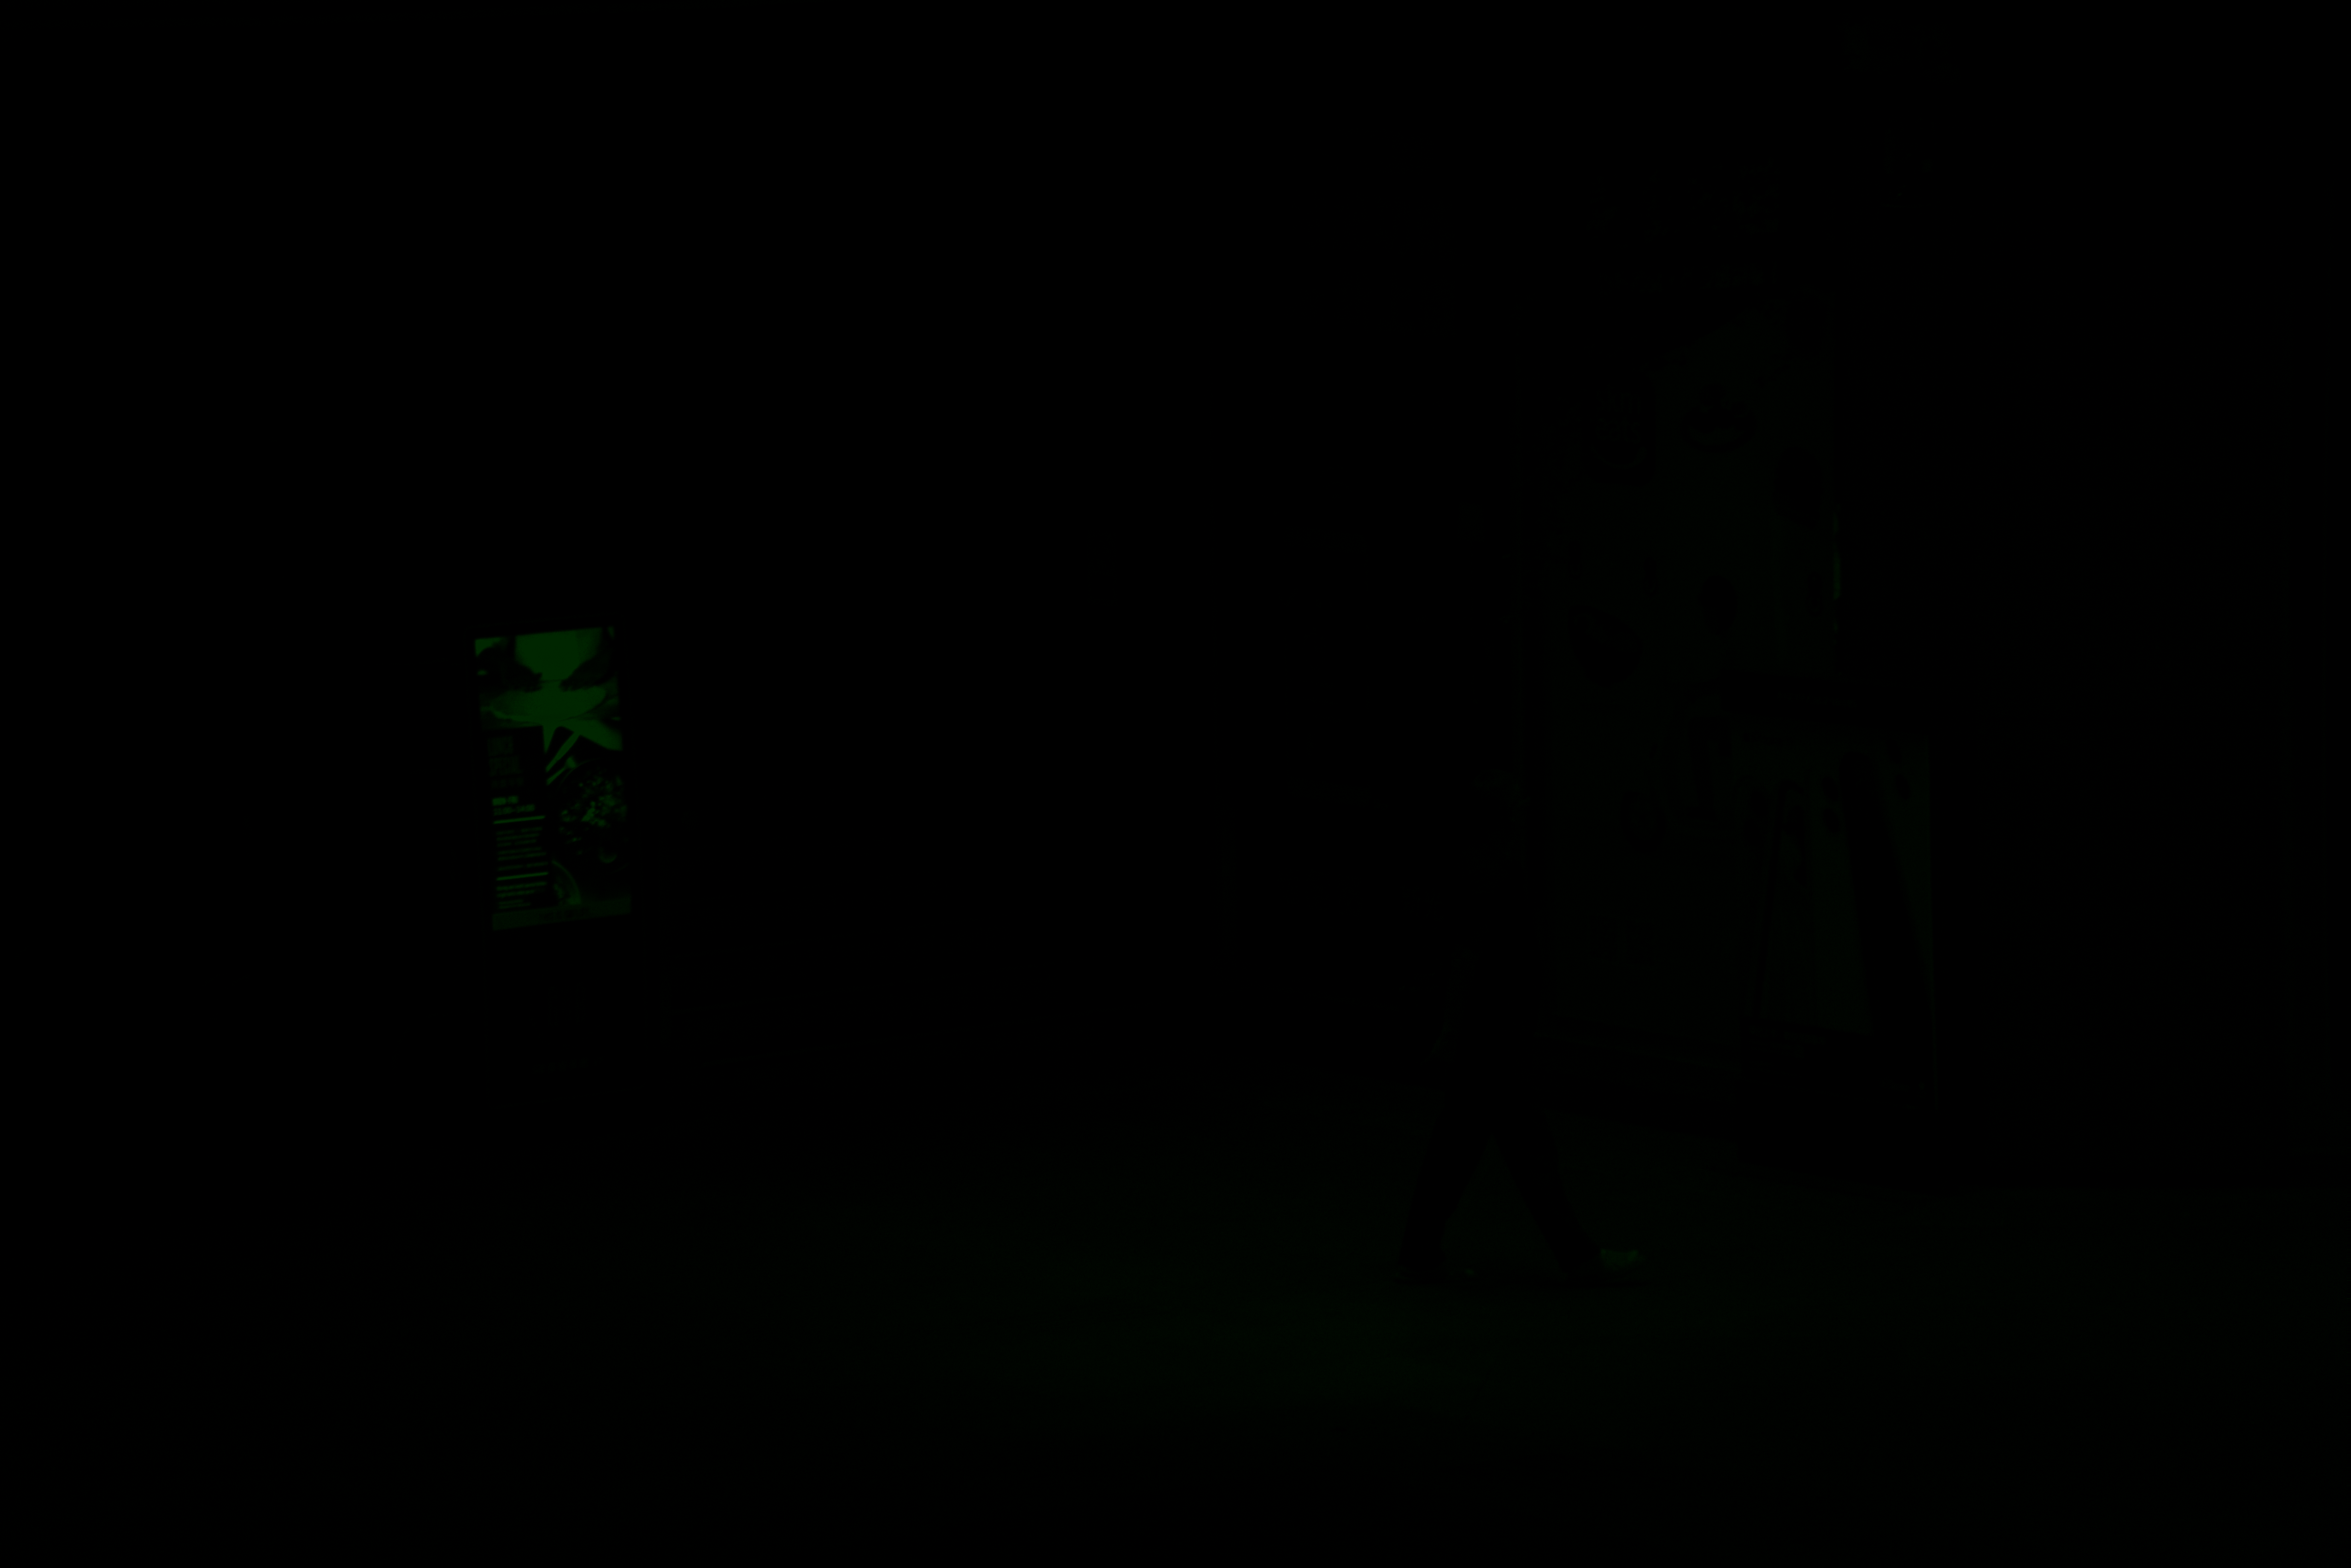

torch.Size([1836, 2752, 3])
(1836, 2752, 3)
Elapsed time: 5.4859514236450195


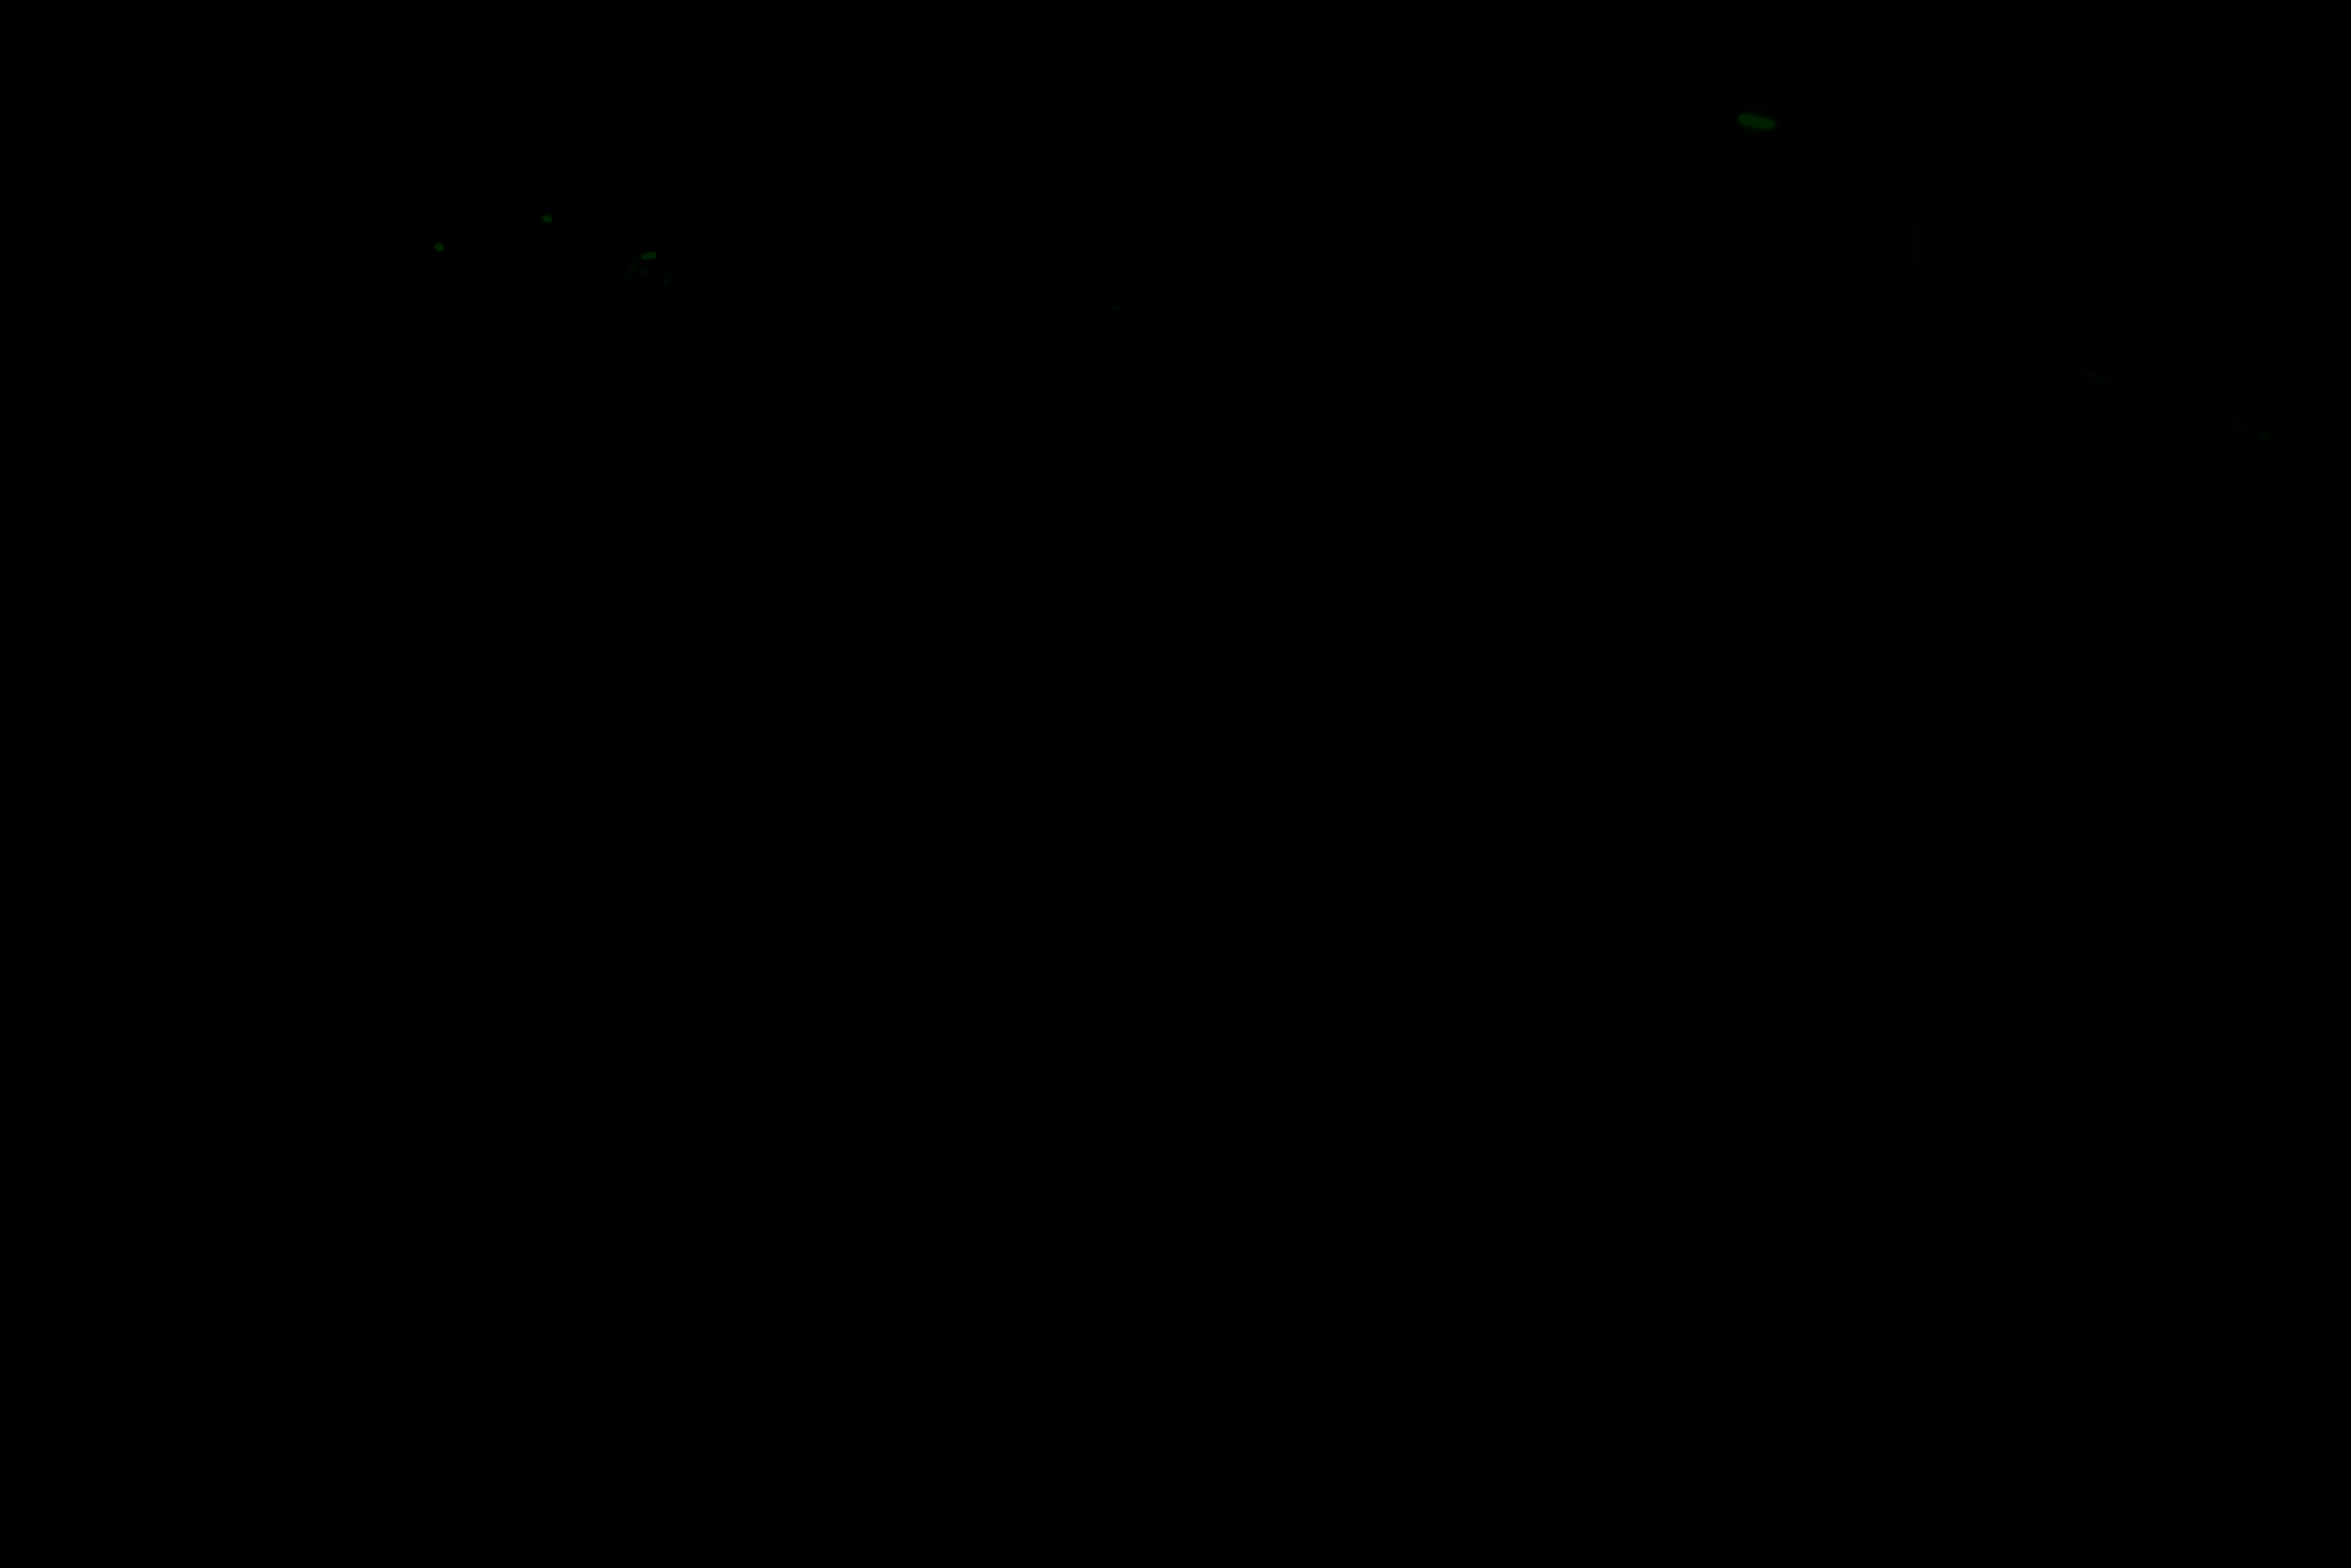

In [ ]:
# To be deleted once Train.py is constructed

def load_classes(csv_reader):
    result = {}

    for line, row in enumerate(csv_reader):
        line += 1

        try:
            class_name, class_id = row
        except ValueError:
            raise(ValueError('line {}: format should be \'class_name,class_id\''.format(line)))
        class_id = int(class_id)

        if class_name in result:
            raise ValueError('line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
    return result


# Draws a caption above the box in an image
def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)


def detect_image(image_path, model_path):

    # Create the model
    model = resnet50(80, pretrained=True)

    if torch.cuda.is_available():
        model = model.cuda()

    model.training = False
    model.eval()

    for image in fred:
      image = image.permute(1,2,0)
      print(image.shape)
      image = image.detach().numpy()
      print(image.shape)
      image_orig = image.copy()

      #image = cv2.imread(os.path.join(image_path, img_name))
      image_orig = image.copy()

      rows, cols, cns = image.shape
          
      smallest_side = min(rows, cols)

      # rescale the image so the smallest side is min_side
      min_side = 608
      max_side = 1024
      scale = min_side / smallest_side

      # check if the largest side is now greater than max_side, which can happen
      # when images have a large aspect ratio
      largest_side = max(rows, cols)

      if largest_side * scale > max_side:
          scale = max_side / largest_side

      # resize the image with the computed scale
      image = cv2.resize(image, (int(round(cols * scale)), int(round((rows * scale)))))
      rows, cols, cns = image.shape

      pad_w = 32 - rows % 32
      pad_h = 32 - cols % 32

      new_image = np.zeros((rows + pad_w, cols + pad_h, cns)).astype(np.float32)
      new_image[:rows, :cols, :] = image.astype(np.float32)
      image = new_image.astype(np.float32)
      image /= 255
      image -= [0.485, 0.456, 0.406]
      image /= [0.229, 0.224, 0.225]
      image = np.expand_dims(image, 0)
      image = np.transpose(image, (0, 3, 1, 2))

      with torch.no_grad():

          image = torch.from_numpy(image)
          if torch.cuda.is_available():
              image = image.cuda()

          st = time.time()
          #print(image.shape, image_orig.shape, scale)
          scores, classification, transformed_anchors = model(image.float())
          print('Elapsed time: {}'.format(time.time() - st))
          idxs = np.where(scores.cpu() > 0.5)
          for j in range(idxs[0].shape[0]):
              bbox = transformed_anchors[idxs[0][j], :]
              x1 = int(bbox[0] / scale)
              y1 = int(bbox[1] / scale)
              x2 = int(bbox[2] / scale)
              y2 = int(bbox[3] / scale)
              label_name = str(int(classification[idxs[0][j]]))
              #print(bbox, classification.shape)
              score = scores[j]
              caption = '{} {:.3f}'.format(label_name, score)
              draw_caption(image_orig, (x1, y1, x2, y2), caption)
              cv2.rectangle(image_orig, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)

      cv2_imshow(image_orig)


if __name__ == '__main__':

    image_dir = 'images'
    model_path = 'coco_resnet_50_map_0_335_state_dict.pt'

    detect_image(image_dir, model_path)

In [ ]:
# csv_eval.py

def compute_overlap(a, b):
    """
    Parameters
    ----------
    a: (N, 4) ndarray of float
    b: (K, 4) ndarray of float
    Returns
    -------
    overlaps: (N, K) ndarray of overlap between boxes and query_boxes
    """
    area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])

    iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
    ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])

    iw = np.maximum(iw, 0)
    ih = np.maximum(ih, 0)

    ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih

    ua = np.maximum(ua, np.finfo(float).eps)

    intersection = iw * ih

    return intersection / ua


def _compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], recall, [1.]))
    mpre = np.concatenate(([0.], precision, [0.]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def _get_detections(dataset, retinanet, score_threshold=0.05, max_detections=100, save_path=None):
    """ Get the detections from the retinanet using the generator.
    The result is a list of lists such that the size is:
        all_detections[num_images][num_classes] = detections[num_detections, 4 + num_classes]
    # Arguments
        dataset         : The generator used to run images through the retinanet.
        retinanet           : The retinanet to run on the images.
        score_threshold : The score confidence threshold to use.
        max_detections  : The maximum number of detections to use per image.
        save_path       : The path to save the images with visualized detections to.
    # Returns
        A list of lists containing the detections for each image in the generator.
    """
    all_detections = [[None for i in range(dataset.num_classes())] for j in range(len(dataset))]

    retinanet.eval()
    
    with torch.no_grad():

        for index in range(len(dataset)):
            data = dataset[index]
            scale = data['scale']

            # run network
            if torch.cuda.is_available():
                scores, labels, boxes = retinanet(data['img'].permute(2, 0, 1).cuda().float().unsqueeze(dim=0))
            else:
                scores, labels, boxes = retinanet(data['img'].permute(2, 0, 1).float().unsqueeze(dim=0))
            scores = scores.cpu().numpy()
            labels = labels.cpu().numpy()
            boxes  = boxes.cpu().numpy()

            # correct boxes for image scale
            boxes /= scale

            # select indices which have a score above the threshold
            indices = np.where(scores > score_threshold)[0]
            if indices.shape[0] > 0:
                # select those scores
                scores = scores[indices]

                # find the order with which to sort the scores
                scores_sort = np.argsort(-scores)[:max_detections]

                # select detections
                image_boxes      = boxes[indices[scores_sort], :]
                image_scores     = scores[scores_sort]
                image_labels     = labels[indices[scores_sort]]
                image_detections = np.concatenate([image_boxes, np.expand_dims(image_scores, axis=1), np.expand_dims(image_labels, axis=1)], axis=1)

                # copy detections to all_detections
                for label in range(dataset.num_classes()):
                    all_detections[index][label] = image_detections[image_detections[:, -1] == label, :-1]
            else:
                # copy detections to all_detections
                for label in range(dataset.num_classes()):
                    all_detections[index][label] = np.zeros((0, 5))

            print('{}/{}'.format(index + 1, len(dataset)), end='\r')

    return all_detections


def _get_annotations(generator):
    """ Get the ground truth annotations from the generator.
    The result is a list of lists such that the size is:
        all_detections[num_images][num_classes] = annotations[num_detections, 5]
    # Arguments
        generator : The generator used to retrieve ground truth annotations.
    # Returns
        A list of lists containing the annotations for each image in the generator.
    """
    all_annotations = [[None for i in range(generator.num_classes())] for j in range(len(generator))]

    for i in range(len(generator)):
        # load the annotations
        annotations = generator.load_annotations(i)

        # copy detections to all_annotations
        for label in range(generator.num_classes()):
            all_annotations[i][label] = annotations[annotations[:, 4] == label, :4].copy()

        print('{}/{}'.format(i + 1, len(generator)), end='\r')

    return all_annotations


def evaluate(
    generator,
    retinanet,
    iou_threshold=0.5,
    score_threshold=0.05,
    max_detections=100,
    save_path=None
):
    """ Evaluate a given dataset using a given retinanet.
    # Arguments
        generator       : The generator that represents the dataset to evaluate.
        retinanet           : The retinanet to evaluate.
        iou_threshold   : The threshold used to consider when a detection is positive or negative.
        score_threshold : The score confidence threshold to use for detections.
        max_detections  : The maximum number of detections to use per image.
        save_path       : The path to save precision recall curve of each label.
    # Returns
        A dict mapping class names to mAP scores.
    """



    # gather all detections and annotations

    all_detections     = _get_detections(generator, retinanet, score_threshold=score_threshold, max_detections=max_detections, save_path=save_path)
    all_annotations    = _get_annotations(generator)

    average_precisions = {}

    for label in range(generator.num_classes()):
        false_positives = np.zeros((0,))
        true_positives  = np.zeros((0,))
        scores          = np.zeros((0,))
        num_annotations = 0.0

        for i in range(len(generator)):
            detections           = all_detections[i][label]
            annotations          = all_annotations[i][label]
            num_annotations     += annotations.shape[0]
            detected_annotations = []

            for d in detections:
                scores = np.append(scores, d[4])

                if annotations.shape[0] == 0:
                    false_positives = np.append(false_positives, 1)
                    true_positives  = np.append(true_positives, 0)
                    continue

                overlaps            = compute_overlap(np.expand_dims(d, axis=0), annotations)
                assigned_annotation = np.argmax(overlaps, axis=1)
                max_overlap         = overlaps[0, assigned_annotation]

                if max_overlap >= iou_threshold and assigned_annotation not in detected_annotations:
                    false_positives = np.append(false_positives, 0)
                    true_positives  = np.append(true_positives, 1)
                    detected_annotations.append(assigned_annotation)
                else:
                    false_positives = np.append(false_positives, 1)
                    true_positives  = np.append(true_positives, 0)

        # no annotations -> AP for this class is 0 (is this correct?)
        if num_annotations == 0:
            average_precisions[label] = 0, 0
            continue

        # sort by score
        indices         = np.argsort(-scores)
        false_positives = false_positives[indices]
        true_positives  = true_positives[indices]

        # compute false positives and true positives
        false_positives = np.cumsum(false_positives)
        true_positives  = np.cumsum(true_positives)

        # compute recall and precision
        recall    = true_positives / num_annotations
        precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

        # compute average precision
        average_precision  = _compute_ap(recall, precision)
        average_precisions[label] = average_precision, num_annotations


    print('\nmAP:')
    for label in range(generator.num_classes()):
        label_name = generator.label_to_name(label)
        print('{}: {}'.format(label_name, average_precisions[label][0]))
        print("Precision: ",precision[-1])
        print("Recall: ",recall[-1])
        
        if save_path!=None:
            plt.plot(recall,precision)
            # naming the x axis 
            plt.xlabel('Recall') 
            # naming the y axis 
            plt.ylabel('Precision') 

            # giving a title to my graph 
            plt.title('Precision Recall curve') 

            # function to show the plot
            plt.savefig(save_path+'/'+label_name+'_precision_recall.jpg')

    return average_precisions

In [ ]:
# Train.py

#assert torch.__version__.split('.')[0] == '1'

print('CUDA available: {}'.format(torch.cuda.is_available()))

csv_train = 'preprocessed_pngs.csv'
csv_classes = 'classes_file.csv'
csv_val = None

epochs = 10

def main(args=None):

    dataset_train = CSVDataset(train_file=csv_train, class_list=csv_classes,
                                   transform=transforms.Compose([Normalizer(), Augmenter(), Resizer()]))

    if csv_val is None:
        dataset_val = None
        print('No validation annotations provided.')
    else:
        dataset_val = CSVDataset(train_file=csv_val, class_list=csv_classes,
                                     transform=transforms.Compose([Normalizer(), Resizer()]))

    sampler = AspectRatioBasedSampler(dataset_train, batch_size=2, drop_last=False)
    dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler)

    if dataset_val is not None:
        sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
        dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)

    retinanet = resnet50(80, pretrained=True)
   
    use_gpu = False

    if use_gpu:
        if torch.cuda.is_available():
            retinanet = retinanet.cuda()

    if torch.cuda.is_available():
        retinanet = torch.nn.DataParallel(retinanet).cuda()
    else:
        retinanet = torch.nn.DataParallel(retinanet)

    retinanet.training = True

    optimizer = optim.Adam(retinanet.parameters(), lr=1e-5)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

    loss_hist = collections.deque(maxlen=500)

    retinanet.train()
    retinanet.module.freeze_bn()

    print('Num training images: {}'.format(len(dataset_train)))

    for epoch_num in range(epochs):

        retinanet.train()
        retinanet.module.freeze_bn()

        epoch_loss = []

        for iter_num, data in enumerate(dataloader_train):
            print(iter_num)
            try:
                optimizer.zero_grad()

                if torch.cuda.is_available():
                    classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot']])
                else:
                    classification_loss, regression_loss = retinanet([data['img'].float(), data['annot']])
                    
                classification_loss = classification_loss.mean()
                regression_loss = regression_loss.mean()

                loss = classification_loss + regression_loss

                if bool(loss == 0):
                    continue

                loss.backward()

                torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)

                optimizer.step()

                loss_hist.append(float(loss))

                epoch_loss.append(float(loss))

                print(
                    'Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                        epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))

                del classification_loss
                del regression_loss
            except Exception as e:
                print(e)
                continue

        if csv_val is not None:

            print('Evaluating dataset')

            mAP = csv_eval.evaluate(dataset_val, retinanet)

        scheduler.step(np.mean(epoch_loss))

        torch.save(retinanet.module, '{}_retinanet_{}.pt'.format('CSV', epoch_num))

    retinanet.eval()

    torch.save(retinanet, 'model_final.pt')


if __name__ == '__main__':
    main()

CUDA available: False
No validation annotations provided.


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Num training images: 80
0
Epoch: 0 | Iteration: 0 | Classification loss: 2.95926 | Regression loss: 1.33929 | Running loss: 4.29855
1
Epoch: 0 | Iteration: 1 | Classification loss: 3.12109 | Regression loss: 1.46568 | Running loss: 4.44266
2
Epoch: 0 | Iteration: 2 | Classification loss: 11.44879 | Regression loss: 1.29236 | Running loss: 7.20882
3


KeyboardInterrupt: ignored

This should probably be at around line 30


    wb = WBNet()
    wb.to(torch.double)
    output = wb(resized_image)

    output = torch.mean(output, 0)
    output = torch.diag(output)



In [ ]:
# To create preprocessed_pngs.csv based on raw_new_Sony_RX100m7_train.csv

import os

path_to_directory = "preprocessed_pngs"
file_names = os.listdir(path_to_directory)

old_file_name = 'raw_new_Sony_RX100m7_train.csv'
new_file_name = "preprocessed_pngs.csv"

with open(old_file_name, "r") as old_file, open(new_file_name, "w") as new_file:
    # Write the header row to the new file
    header = "img_path,x1,y1,x2,y2,class_name\n"
    new_file.write(header)
    
    # Loop over the lines in the old file
    for line in old_file:
        # Split the line into fields
        fields = line.strip().split(",")
        img_path = fields[0][13:]+'.png'
        # Check if the image file is in the preprocessed_pngs directory
        if os.path.basename(img_path) in file_names:
            # Modify the img_path to start with preprocessed_pngs/
            img_path = "preprocessed_pngs/" + os.path.basename(img_path)
            # Write the modified line to the new file
            new_line = f"{img_path},{fields[1]},{fields[2]},{fields[3]},{fields[4]},{fields[5]}\n"
            new_file.write(new_line)